In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, LSTM, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
df=pd.read_csv('./INFY.csv',index_col='Date',parse_dates=True)

In [3]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,INFY,EQ,1333.80,1332.25,1351.30,1321.00,1345.00,1343.55,1343.19,7088606,9.521361e+14,130375.0,4218129.0,0.5951
2021-04-27,INFY,EQ,1343.55,1346.00,1353.00,1340.15,1347.50,1348.50,1346.89,3636115,4.897445e+14,145974.0,1871084.0,0.5146
2021-04-28,INFY,EQ,1348.50,1358.00,1359.50,1344.60,1355.80,1356.00,1353.45,4879234,6.603778e+14,137376.0,2857134.0,0.5856


In [4]:
df['Date']=df.index

In [6]:
start_date='2020-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [7]:
df=df.loc[mask]

In [8]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [9]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [10]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [11]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [12]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (201, 50) Y.shape (201,)


In [13]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

LSTM+CNN

In [14]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPool1D()(x)
x=Dense(1)(x)
model_lstm_cnn=Model(i,x)
model_lstm_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 25)            100       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 25)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 51    

In [15]:
check_point_lstm_cnn=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [17]:
model_lstm_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [18]:
r=model_lstm_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_cnn]
)

Epoch 1/100
4/4 [==============================] - 1s 141ms/step - loss: 432.7306 - mae: 14.8290 - mse: 432.7306 - val_loss: 360.2850 - val_mae: 14.9827 - val_mse: 360.2850
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 429.8533 - mae: 14.8197 - mse: 429.8533 - val_loss: 354.0399 - val_mae: 14.8911 - val_mse: 354.0399
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 426.4089 - mae: 14.7799 - mse: 426.4089 - val_loss: 356.9810 - val_mae: 14.9326 - val_mse: 356.9810
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 421.4096 - mae: 14.5903 - mse: 421.4096 - val_loss: 364.9499 - val_mae: 15.0596 - val_mse: 364.9499
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 419.3456 - mae: 14.5267 - mse: 419.3456 - val_loss: 367.7633 - val_mae: 15.1091 - val_mse: 367.7633
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 417.9744 - mae: 14.4954 - mse: 417.9744 - val_loss: 367.0439 - val_

LSTM+GRU

In [20]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=GRU(200,return_sequences=True)(x)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm_gru=Model(i,x)
model_lstm_gru.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 200)           161600    
                                                                 
 lstm_5 (LSTM)               (None, 50, 200)           320800    
                                                                 
 dense_8 (Dense)             (None, 50, 100)           20100     
                                                                 
 dense_9 (Dense)             (None, 50, 50)            5050      
                                                                 
 gru_2 (GRU)                 (None, 50, 200)           151200    
                                                                 
 gru_3 (GRU)                 (None, 50, 200)           2412

In [21]:
check_point_lstm_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [22]:
model_lstm_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [23]:
r=model_lstm_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_gru]
)

Epoch 1/100
4/4 [==============================] - 12s 1s/step - loss: 443.8052 - mae: 14.9388 - mse: 443.8052 - val_loss: 352.5326 - val_mae: 14.9016 - val_mse: 352.5326
Epoch 2/100
4/4 [==============================] - 2s 623ms/step - loss: 440.1114 - mae: 14.8454 - mse: 440.1114 - val_loss: 344.5203 - val_mae: 14.7836 - val_mse: 344.5203
Epoch 3/100
4/4 [==============================] - 2s 618ms/step - loss: 439.5638 - mae: 14.8739 - mse: 439.5638 - val_loss: 342.5874 - val_mae: 14.7382 - val_mse: 342.5874
Epoch 4/100
4/4 [==============================] - 2s 606ms/step - loss: 438.7240 - mae: 14.8424 - mse: 438.7240 - val_loss: 345.3532 - val_mae: 14.7992 - val_mse: 345.3532
Epoch 5/100
4/4 [==============================] - 2s 597ms/step - loss: 437.6398 - mae: 14.7994 - mse: 437.6398 - val_loss: 345.8445 - val_mae: 14.8086 - val_mse: 345.8445
Epoch 6/100
4/4 [==============================] - 2s 595ms/step - loss: 437.9554 - mae: 14.7952 - mse: 437.9554 - val_loss: 346.4649 - v

Predictions



In [24]:
train_idx[:T+1]=False

In [25]:
Ptrain_lstm_cnn=model_lstm_cnn.predict(Xtrain).flatten()
Ptest_lstm_cnn=model_lstm_cnn.predict(Xtest).flatten()

In [26]:
Ptrain_lstm_gru=model_lstm_gru.predict(Xtrain).flatten()
Ptest_lstm_gru=model_lstm_gru.predict(Xtest).flatten()

In [27]:
df.loc[train_idx,'Diff LSTM+CNN train prediction']=Ptrain_lstm_cnn
df.loc[test_idx,'Diff LSTM+CNN test prediction']=Ptest_lstm_cnn

In [28]:
df.loc[train_idx,'Diff LSTM+GRU train prediction']=Ptrain_lstm_gru
df.loc[test_idx,'Diff LSTM+GRU test prediction']=Ptest_lstm_gru

In [29]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [30]:
last_train=train.iloc[-1]['Prev Close']

In [31]:
df.loc[train_idx,'train_LSTM_CNN']=prev[train_idx]+Ptrain_lstm_cnn
df.loc[test_idx,'Prediction_LSTM_CNN']=prev[test_idx]+Ptest_lstm_cnn

In [32]:
df.loc[train_idx,'train_LSTM_GRU']=prev[train_idx]+Ptrain_lstm_gru
df.loc[test_idx,'Prediction_LSTM_GRU']=prev[test_idx]+Ptest_lstm_gru

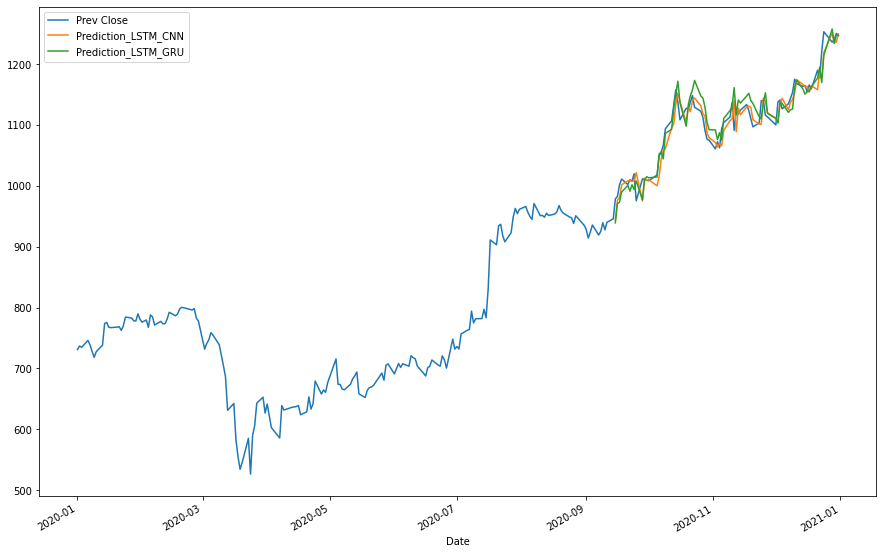

In [34]:
df[['Prev Close' ,'Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

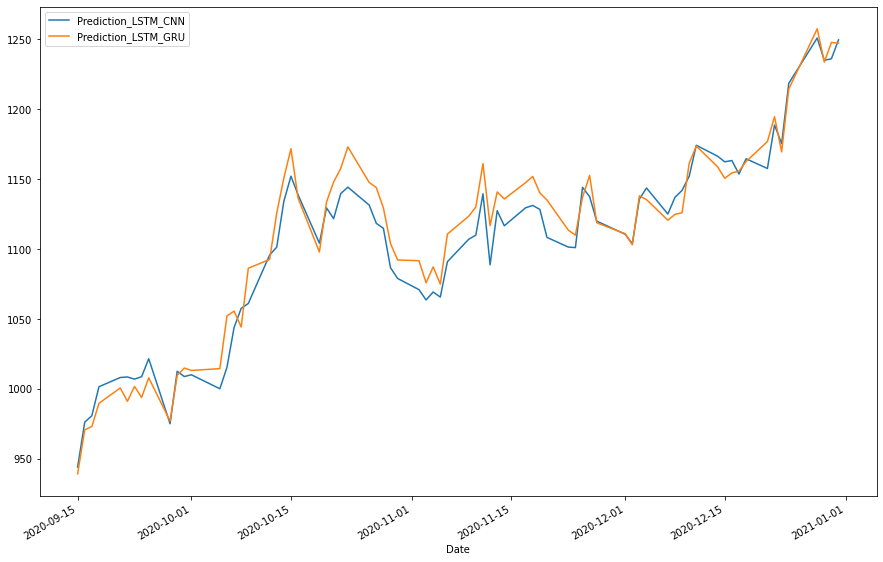

In [35]:
df[['Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

In [46]:
pred_lstm_cnn=df['Prediction_LSTM_CNN']
pred_lstm_cnn.dropna(inplace=True)

In [47]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

19.491749602905532


In [48]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_cnn)
print(error)

15.217374129931132


In [49]:
r2_score(test['Prev Close'],pred_lstm_cnn)

0.9143547333626019

In [50]:
pred_lstm_gru=df['Prediction_LSTM_GRU']
pred_lstm_gru.dropna(inplace=True)

In [51]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

19.491749602905532


In [52]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_gru)
print(error)

17.718006477832798


In [53]:
r2_score(test['Prev Close'],pred_lstm_gru)

0.8849091228254728